<a href="https://colab.research.google.com/github/salimHarthi/Capstone-Project---The-Battle-of-Neighborhoods/blob/main/Predicting_Rent_prices_in_Toronto_Canada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Rent prices in Toronto Canada
People are renting houses and apartments to live in for years or months. It is important for people who rent a house or an apartment to get a fair price for the place they are renting.
By utilizing the information of the rent of different properties we can build a model that will accurately predict a fair price for rent according to different factors such as number of bathroom and bedrooms, number of different venues nearby and more.


In [1]:
# importing 
import requests, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
%matplotlib inline

In [2]:
# connecting to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### To find the dataset [here](https://www.kaggle.com/rajacsp/toronto-apartment-price)

In [3]:
# Reading kaggle data
df = pd.read_csv('/content/gdrive/MyDrive/ibm final/Toronto_apartment_rentals_2018.csv')
df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)
df.head()

,Bedroom,Bathroom,Den,Address,Lat,Long,Price
0,2,2.0,0,"3985 Grand Park Drive, 3985 Grand Park Dr, Mis...",43.581639,-79.648193,2450.0
1,1,1.0,1,"361 Front St W, Toronto, ON M5V 3R5, Canada",43.643051,-79.391643,2150.0
2,1,1.0,0,"89 McGill Street, Toronto, ON, M5B 0B1",43.660605,-79.378635,1950.0
3,2,2.0,0,"10 York Street, Toronto, ON, M5J 0E1",43.641087,-79.381405,2900.0
4,1,1.0,0,"80 St Patrick St, Toronto, ON M5T 2X6, Canada",43.652487,-79.389622,1800.0


In [4]:
# checking data type 
df.dtypes

Bedroom       int64
Bathroom    float64
Den           int64
Address      object
Lat         float64
Long        float64
Price       float64
dtype: object

### preforming quick analysis using pandas
Finding
- count of data points
- mean
- std
- max 


In [5]:
# quick analysis using pandas
df.describe()

,Bedroom,Bathroom,Den,Lat,Long,Price
count,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000
mean,1.370107,1.237544,0.153025,43.703532,-79.500326,3627.912811
std,0.553493,0.431997,0.360172,0.692689,1.760654,27530.542058
min,1.000000,1.000000,0.000000,42.985767,-114.082215,65.000000
25%,1.000000,1.000000,0.000000,43.641355,-79.414319,1759.250000
50%,1.000000,1.000000,0.000000,43.650560,-79.387295,2100.000000
75%,2.000000,1.000000,0.000000,43.666613,-79.377198,2500.000000
max,3.000000,3.000000,1.000000,56.130366,-73.576385,535000.000000


# get the dat from API

This section for getting data from foursquare api.
- The data related to the venues nearby the property
- it will get venues in 500m radius

In [ ]:
# add credential 
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20210705' 
LIMIT = 100

In [ ]:
# setup url and basic parameters
url = 'https://api.foursquare.com/v2/venues/explore'

params = dict(
client_id=CLIENT_ID,
client_secret=CLIENT_SECRET,
radius = 500,
v=VERSION,
ll='',
)


### Getting important data from the API
- Lat
- Long
- Venue name
- Categories
- Categories icon


In [ ]:
venues_list = []
for index, row in df.iterrows():
  params['ll'] = str(row['Lat'])+","+str(row['Long'])
  resp = requests.get(url=url, params=params)
  data = json.loads(resp.text)
  for v in data["response"]['groups'][0]['items']:
    new_venue = {}
    new_venue['id'] = index
    new_venue['venue_class'] = v["venue"]['categories'][0]['icon']['prefix']
    new_venue['venue_type'] = v["venue"]['categories'][0]['name']
    new_venue['venue_name'] = v["venue"]['name']
    new_venue['venue_lat'] = v["venue"]['location']['lat']
    new_venue['venue_long'] =v["venue"]['location']['lng']
    venues_list.append(new_venue)


In [ ]:
all_venuse = pd.DataFrame(venues_list)
all_venuse.to_csv('venuse.csv',index=False)

In [ ]:
all_venuse['venue_type'].unique()

# Data cleaning 
Cleaning the data consist of removing ($) from Price column then convert it to Float.
For cleaning the API data, the Categories icon was reduced to main category for example.
The following Categories icon:
```
https://ss3.4sqi.net/img/categories_v2/shops/salon_barber_
```
```
‘https:’, ‘’, ‘ss3.4sqi.net’, ‘img’,’categories_v2’,’shops’,’salon_barber_’
```
it reduced to shops. The process output was 8 main categories:
- food
- Shops
- Building
- Art entertainment 
- Travel
- Nightlife 
- Parks outdoors 
- Education




In [6]:
venuse_df = pd.read_csv('/content/gdrive/MyDrive/ibm final/venuse (1).csv')
venuse_df.head()

,id,venue_class,venue_type,venue_name,venue_lat,venue_long
0,0,https://ss3.4sqi.net/img/categories_v2/food/it...,Italian Restaurant,On A Bun,43.578680,-79.650076
1,0,https://ss3.4sqi.net/img/categories_v2/shops/p...,Paper / Office Supplies Store,Staples,43.580003,-79.648682
2,0,https://ss3.4sqi.net/img/categories_v2/shops/p...,Pharmacy,Shoppers Drug Mart,43.581682,-79.648967
3,0,https://ss3.4sqi.net/img/categories_v2/shops/d...,Department Store,Winners,43.579165,-79.646638
4,0,https://ss3.4sqi.net/img/categories_v2/food/de...,Dessert Shop,Dunk 'n Dip,43.580790,-79.649510


In [7]:
def get_venue_type(x):
  xarr = x.split('/')
  return xarr[5]

In [8]:
venuse_df['venue_class']= venuse_df['venue_class'].apply(lambda x:get_venue_type(x))
venuse_df['venue_class']=venuse_df['venue_class'].fillna(venuse_df['venue_type'])

The Id coulmn is the index of the property

In [139]:
venuse_df.head()

,id,venue_class,venue_type,venue_name,venue_lat,venue_long
0,0,food,Italian Restaurant,On A Bun,43.578680,-79.650076
1,0,shops,Paper / Office Supplies Store,Staples,43.580003,-79.648682
2,0,shops,Pharmacy,Shoppers Drug Mart,43.581682,-79.648967
3,0,shops,Department Store,Winners,43.579165,-79.646638
4,0,food,Dessert Shop,Dunk 'n Dip,43.580790,-79.649510


In [10]:
venuse_df['venue_class'].describe()

count     28070
unique        8
top        food
freq      15525
Name: venue_class, dtype: object

Margining all features into one table.

In [12]:
merged_df = df.copy()
merged_df[venuse_df['venue_class'].unique()]= 0
for index, row in venuse_df.iterrows():
  merged_df[row['venue_class']][row['id']]+=1

merged_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Bedroom,Bathroom,Den,Address,Lat,Long,Price,food,shops,building,arts_entertainment,travel,nightlife,parks_outdoors,education
0,2,2.0,0,"3985 Grand Park Drive, 3985 Grand Park Dr, Mis...",43.581639,-79.648193,2450.0,10,7,1,1,1,0,0,0
1,1,1.0,1,"361 Front St W, Toronto, ON M5V 3R5, Canada",43.643051,-79.391643,2150.0,15,2,3,6,1,2,1,0
2,1,1.0,0,"89 McGill Street, Toronto, ON, M5B 0B1",43.660605,-79.378635,1950.0,19,3,0,3,1,1,3,0
3,2,2.0,0,"10 York Street, Toronto, ON, M5J 0E1",43.641087,-79.381405,2900.0,10,3,1,4,3,2,7,0
4,1,1.0,0,"80 St Patrick St, Toronto, ON M5T 2X6, Canada",43.652487,-79.389622,1800.0,12,4,0,6,1,3,3,1


# visualization 
Relationship between features and target



In [13]:
# location of the properties 
m = folium.Map(location=[43.6532, -79.3832], tiles="cartodbpositron", zoom_start=8)
properties_lat_long = [[res[4], res[5]] for res in merged_df.values]
HeatMap(properties_lat_long).add_to(m)
m

### 3.1	Relationship between features (Bathrooms, Bedrooms, Den, Latitude, and Longitude) and target (rent)

As shown in Figure the increase of number of bathrooms and bedrooms cause the minimum and maximum amount rent increases. 
The properties with den has a higher minimum rent in compare to the properties without den as shown in Figure.
As shown in Figure most of the properties are closer to (44, -80) latitude, and longitude.

[(0.0, 7000.0)]

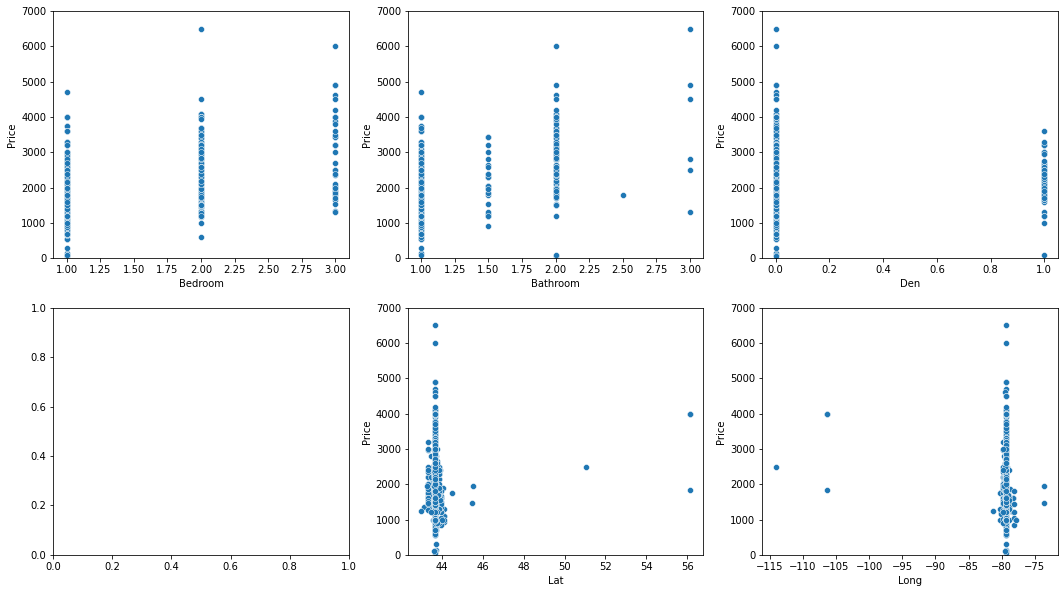

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
ylim=(0, 7000)
Bedroom = sns.scatterplot(ax=axes[0, 0], data=df, x="Bedroom", y="Price")
Bedroom.set(ylim=ylim)
Bathroom =sns.scatterplot(ax=axes[0, 1],data=df, x="Bathroom", y="Price")
Bathroom.set(ylim=ylim)
Den =sns.scatterplot(ax=axes[0, 2],data=df, x="Den", y="Price")
Den.set(ylim=ylim)
Lat = sns.scatterplot(ax=axes[1, 1],data=df, x="Lat", y="Price")
Lat.set(ylim=ylim)
Long= sns.scatterplot(ax=axes[1, 2],data=df, x="Long", y="Price")
Long.set(ylim=ylim)

### Relationship between features (Latitude, and Longitude) and target (rent)
As shown in Figure most of the property from latitude, and longitude (43.65,-79.4) the lower the maximum rent price is.


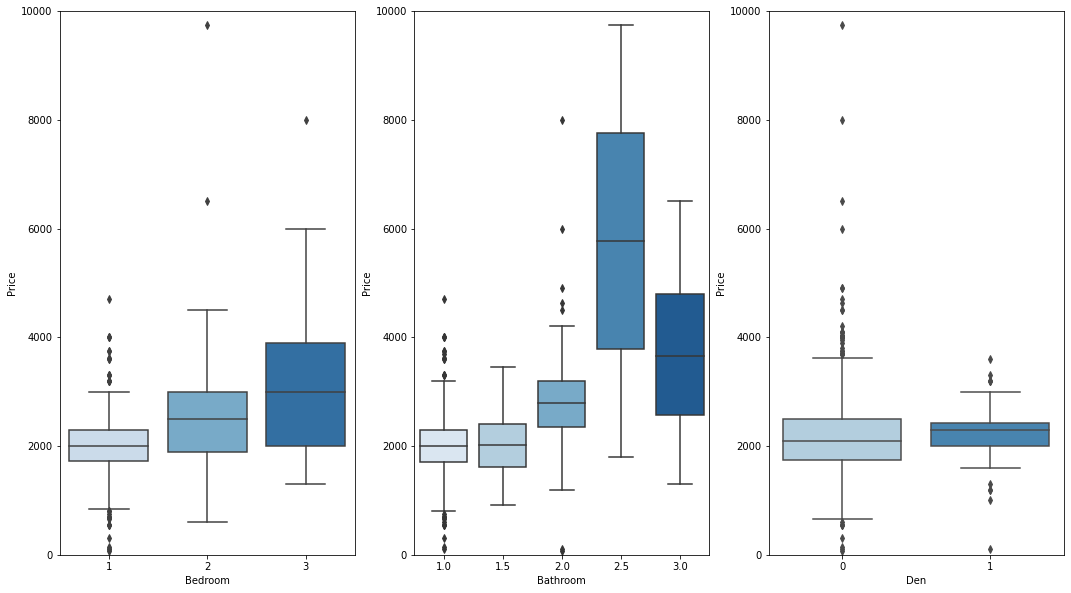

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 10))
ylim=(0, 10000)
counter = 0
for col in ['Bedroom',	'Bathroom',	'Den']:
  a = sns.boxplot(ax=axes[counter],data=merged_df, x=col, y='Price', palette="Blues")
  a.set(ylim=ylim)
  counter +=1

plt.show()

[(0.0, 7000.0), (-80.0, -79.0)]

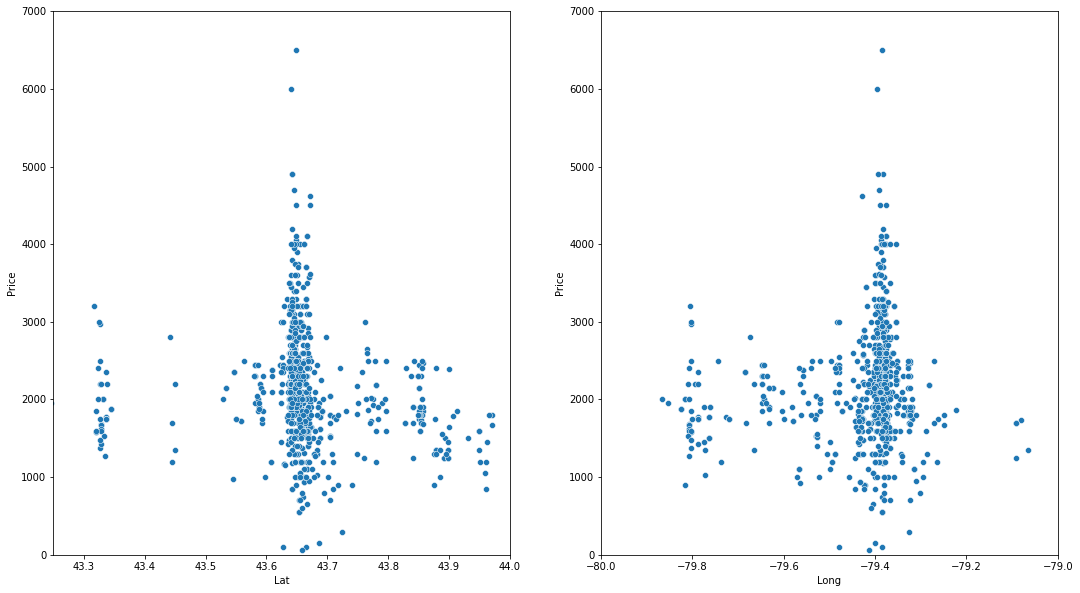

In [ ]:
# closer look into lat an long
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
ylim=(0, 7000)
Lat = sns.scatterplot(ax=axes[0],data=df, x="Lat", y="Price")
Lat.set(ylim=ylim,xlim=(43.25,44))
Long= sns.scatterplot(ax=axes[1],data=df, x="Long", y="Price")
Long.set(ylim=ylim,xlim=(-80,-79))

###	Relationship between 8 main categories and target (rent)
As shown in Figure  the in crease in number of travel, parks_outdoors, and arts_entertainment, cause the minimum and maximum amount rent increases.

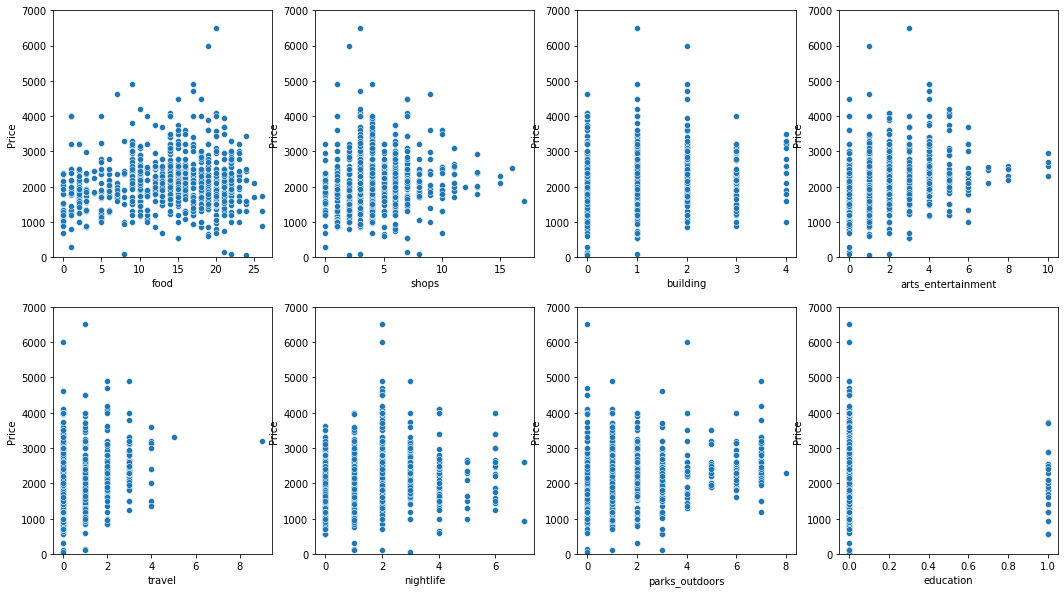

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
ylim=(0, 7000)
counter = 0
rows = 0
for col in venuse_df['venue_class'].unique():
  if counter ==4:
    counter = 0
    rows+=1
  a= sns.scatterplot(ax=axes[rows,counter],data=merged_df, x=col, y="Price")
  a.set(ylim=ylim)
  counter +=1

As shown in figure the change in number of occurrences changes the range of the price

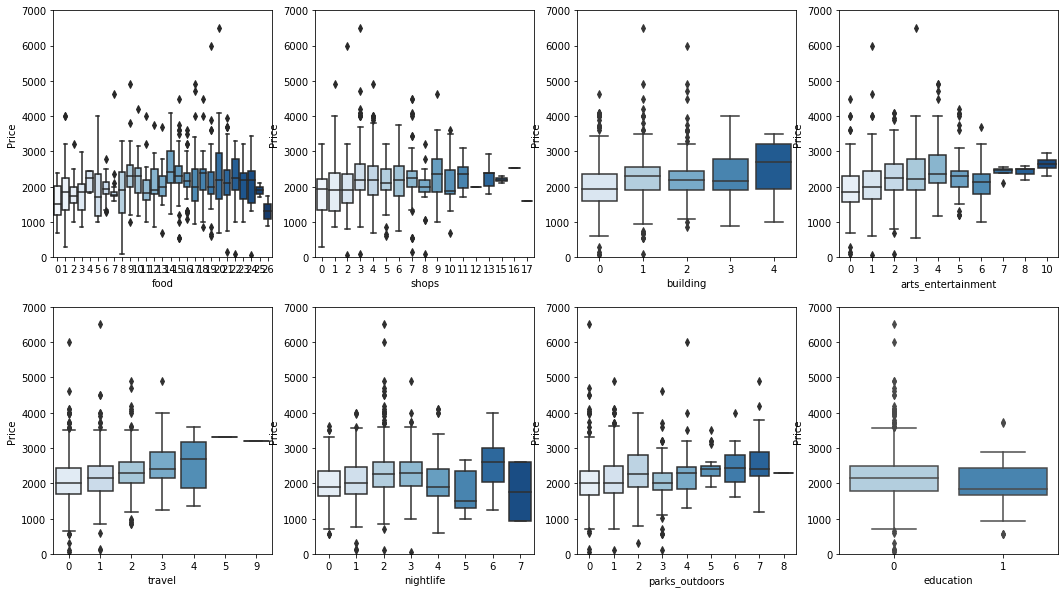

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
ylim=(0, 7000)
counter = 0
rows = 0
for col in venuse_df['venue_class'].unique():
  if counter ==4:
    counter = 0
    rows+=1
  a = sns.boxplot(ax=axes[rows,counter],data=merged_df, x=col, y='Price', palette="Blues")
  # a= sns.scatterplot(ax=axes[rows,counter],data=merged_df, x=col, y="Price")
  a.set(ylim=ylim)
  counter +=1

plt.show()

# model

To Predict the rent of a property a regression model is the best fit. In this case 3 regression models have been used:
- Gradient Boosting Regressor
- Random Forest Regressor
- KNN Regressor


In [15]:
all_scorec = {}
predict_vs_true_df= {}

In [16]:
def predict_vs_true(model,x,y):
  predict_vs_true = pd.DataFrame( columns=['true', 'predict'])
  predict_vs_true['true'] =  y
  predict_vs_true['predict'] =  model.predict(x)
  predict_vs_true.reset_index(inplace=True,drop=True)
  return predict_vs_true

In [17]:
featuers = list(venuse_df['venue_class'].unique())+['Bedroom',	'Bathroom',	'Den', 'Lat', 'Long']

In [107]:
# spite data
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
x = merged_df[featuers]
y= merged_df['Price']	
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 4)

### Gradient Boosting Regressor

In [108]:
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
     max_depth=6, random_state=0).fit(x_train, y_train)

predict_vs_true_df['GradientBoostingRegressor'] =predict_vs_true(clf,x_test, y_test)
all_scorec["GradientBoostingRegressor"] = clf.score(x_test, y_test)
all_scorec["GradientBoostingRegressor"]

9883.748843278796

### Random Forest Regressor

In [109]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=4, random_state=0)
regr.fit(x_train,y_train)
predict_vs_true_df['RandomForestRegressor'] =predict_vs_true(regr,x_test, y_test)
all_scorec["RandomForestRegressor"] = regr.score(x_test,y_test)
all_scorec["RandomForestRegressor"]

13880.23783157314

### KNN Regressor

In [110]:
from sklearn.neighbors import KNeighborsRegressor
knnreg = KNeighborsRegressor(n_neighbors=3)
knnreg.fit(x_train,y_train)
predict_vs_true_df['KNeighborsRegressor'] =predict_vs_true(knnreg,x_test, y_test)
all_scorec["KNeighborsRegressor"] = knnreg.score(x_test,y_test)
all_scorec["KNeighborsRegressor"]

9876.807558118424

The models that have been used to predict the rent value had performed closely. The average in the accuracy between the models was 84% with KNN Regressor

In [111]:
all_scorec

{'GradientBoostingRegressor': 0.8838783314033397,
 'KNeighborsRegressor': 0.8840413769424407,
 'RandomForestRegressor': 0.7709851305724758}

The predicted value and real value for each property. Figure confirms that the models are predicting good values not randomly selecting a value

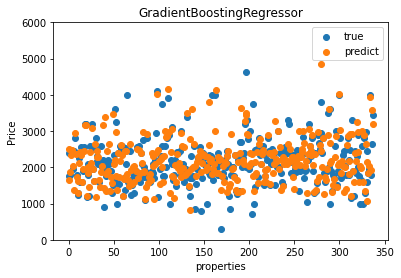

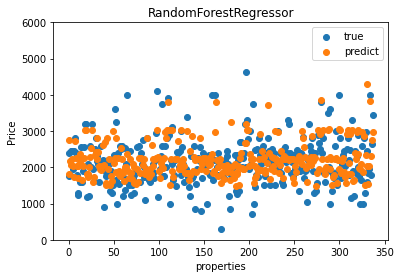

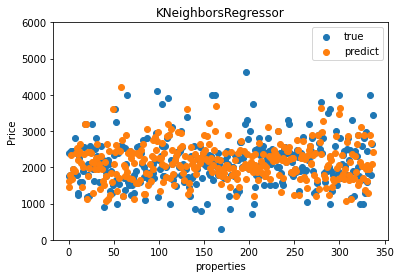

In [138]:
predict_vs_true_id = predict_vs_true_df['KNeighborsRegressor'].index.values
for key in predict_vs_true_df:
  fig, ax = plt.subplots()
  ax.scatter(predict_vs_true_id,predict_vs_true_df[key]["true"],label="true")
  ax.scatter(predict_vs_true_id,predict_vs_true_df[key]["predict"],label='predict')
  plt.title(key)
  plt.xlabel("properties")
  plt.ylabel("Price")
  plt.legend()
  ax.set_ylim([0,6000])
